## 3.4 电影评论分类：二分类问题
### 3.4.1IMDB数据集
    本节使用IMDB数据集，它包含来自互联网电影数据库（IMDB）的50,000条严重两极分化的评论。数据集被分为用于训练的25000条评论与用于测试的25000条评论，训练集和测试集都包含50%的正面评论和50%的负面评论。
    为什么要将训练集和测试集分开？因为你不应该将训练机器学习模型的同一批数据再用于测试模型！模型在训练数据上的表现很好，并不意味着它在前所未见的数据上也会表现得很好，而且你真正关心的是模型在新数据上的性能（因为你已经知道了训练数据对应的标签，显然不再需要模型来进行预测）。例如，你的模型最终可能只是记住了训练样本和目标值之间的映射关系，但这对在前所未见的数据上进行预测毫无用处。下一章将会更详细地讨论这一点。
    与MNIST数据集一样，IMDB数据集也内置于Keras库。它已经过预处理：评论（单词序列）已经被转换为整数序列，其中每个整数代表字典中的某个单词。    

In [3]:
from tensorflow.keras.datasets import imdb 
# 下列代码将会加载IMDB数据集（第一次运行时会下载大约80MB的数据）。
# 参数num_words=10000将会保留训练数据中前10,000个最常出现的单词，低频单词将会被舍弃。
# train_data和test_data这两个变量都是评论组成的列表，每条评论又是单词索引组成的列表（表示一系列单词）。
# train_labels和test_labels都是0和1组成的列表，其中0代表负面（negative），1代表正面（positive）。
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# word_index是一个将单词映射为整数索引的字典
word_index = imdb.get_word_index()  
# 键值颠倒，将整数索引映射为单词
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 将评论解码。注意，索引减去了3，因为0、1、2是为“padding”（填充）、“start of sequence”（ 序列开始）、
# “unknown”（未知词）分别保留的索引
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

2023-05-04 14:20:09.005758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1641221/1641221 [==============================] - 1s 1us/step


### 3.4.2　准备数据
你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种。
* 填充列表，序列短的补0，使其具有相同的长度,，再将列表转换成形状为(samples, word_indices)的整数张量，然后网络第一层使用能处理这种整数张量的层（即Embedding层，本书后面会详细介绍）。
* 对列表进行one-hot编码，将其转换为0和1组成的向量。举个例子，序列[3, 5]将会被转换为10,000维向量，只有索引为3和5的元素是1，其余元素都是0。然后网络第一层可以用Dense层，它能够处理浮点数向量数据。

下面我们采用后一种方法将数据向量化。为了加深理解，你可以手动实现这一方法，如下所示。

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32') 
y_test = np.asarray(test_labels).astype('float32')

### 3.4.3　构建网络
输入数据是向量，而标签是标量（1和0），这是你会遇到的最简单的情况。有一类网络在这种问题上表现很好，就是带有relu激活的全连接层（Dense）的简单堆叠，比如Dense(16, activation='relu')。
传入Dense层的参数（16）是该层隐藏单元的个数。一个隐藏单元（hidden  unit）是该层表示空间的一个维度。我们在第2章讲过，每个带有relu激活的Dense层都实现了下列张量运算：
output = relu(dot(W, input) + b)
16个隐藏单元对应的权重矩阵W的形状为(input_dimension, 16)，与W做点积相当于将输入数据投影到16维表示空间中（然后再加上偏置向量b并应用relu运算）。你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）。
对于这种Dense层的堆叠，你需要确定以下两个关键架构：
* 网络有多少层；
* 每层有多少个隐藏单元。
第4章中的原则将会指导你对上述问题做出选择。现在你只需要相信我选择的下列架构：
* 两个中间层，每层都有16个隐藏单元；
* 第三层输出一个标量，预测当前评论的情感。
中间层使用relu作为激活函数，最后一层使用sigmoid激活以输出一个0~1范围内的概率值（表示样本的目标值等于1的可能性，即评论为正面的可能性）。relu（rectified  linear  unit，整流线性单元）函数将所有负值归零（见图3-4）， 而sigmoid函数则将任意值“压缩”到[0, 1]区间内（见图3-5），其输出值可以看作概率值。
![](https://gitee.com/shawn2gao/myimg/raw/master/markdown/2023-04/Snipaste_2023-04-22_10-24-40.png)
![](https://gitee.com/shawn2gao/myimg/raw/master/markdown/2023-04/Snipaste_2023-04-22_10-25-26.png)


In [ ]:
# 代码清单3-3 模型定义
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


> 什么是激活函数？为什么要使用激活函数？
> 如果没有relu等激活函数（也叫非线性），Dense层将只包含两个线性运算——点积和加法：
> $$output = dot(W, input) + b$$
> 这样Dense层就只能学习输入数据的线性变换（仿射变换）：该层的假设空间是从输入数据到16位空间所有可> 能的线性变换集合。这种假设空间非常有限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍是线性> 运算，添加层数并不会扩展假设空间。
> 为了得到更丰富的假设空间，从而充分利用多层表示的优势，你需要添加非线性或激活函数。relu是深度学习> 中最常用的激活函数，但还有许多其他函数可选，它们都有类似的奇怪名称，比如prelu、elu等。

最后，你需要选择损失函数和优化器。由于你面对的是一个二分类问题，网络输出是一个概率值（网络最后一层使用sigmoid激活函数，仅包含一个单元），那么最好使用binary_crossentropy（二元交叉熵）损失。这并不是唯一可行的选择，比如你还可以使用mean_squared_error（均方误差）。但对于输出概率值的模型，交叉熵（crossentropy）往往是最好的选择。交叉熵是来自于信息论领域的概念，用于衡量概率分布之间的距离，在这个例子中就是真实分布与预测值之间的距离。

下面的步骤是用rmsprop优化器和binary_crossentropy损失函数来配置模型。注意，我们还在训练过程中监控精度。

In [ ]:
#3-4 编译模型
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


上述代码将优化器、损失函数和指标作为字符串传入，这是因为rmsprop、binary_crossentropy和accuracy都是Keras内置的一部分。有时你可能希望配置自定义优化器的参数，或者传入自定义的损失函数或指标函数。前者可通过向optimizer参数传入一个优化器类实例来实现，如代码清单3-5所示；后者可通过向loss和metrics参数传入函数对象来实现，如代码清单3-6所示。

In [ ]:
# 3-5 配置优化器
from tensorflow.keras import optimizers 
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 3-6 使用自定义的损失和指标
from tensorflow.keras import losses
from tensorflow.keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### 3.4.4 验证你的方法
为了在训练过程中监控模型在前所未见的数据上的精度，你需要将原始训练数据留出10,000个样本作为验证集。


In [ ]:
# 3-7 准备验证集
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

现在使用512个样本组成的小批量，将模型训练20个轮次（即对x_train和y_train两个张量中的所有样本进行20次迭代）。与此同时，你还要监控在留出的10  000个样本上的损失和精度。你可以通过将验证数据传入validation_data参数来完成。

In [ ]:
# 3-8 训练模型
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 132us/sample - loss: 0.5440 - acc: 0.7671 - val_loss: 0.4263 - val_acc: 0.8541
Epoch 2/20
15000/15000 [==============================] - 1s 81us/sample - loss: 0.3377 - acc: 0.9004 - val_loss: 0.3250 - val_acc: 0.8838
Epoch 3/20
15000/15000 [==============================] - 1s 79us/sample - loss: 0.2434 - acc: 0.9230 - val_loss: 0.2854 - val_acc: 0.8891
Epoch 4/20
15000/15000 [==============================] - 1s 75us/sample - loss: 0.1898 - acc: 0.9404 - val_loss: 0.2777 - val_acc: 0.8900
Epoch 5/20
15000/15000 [==============================] - 1s 76us/sample - loss: 0.1514 - acc: 0.9536 - val_loss: 0.2790 - val_acc: 0.8897
Epoch 6/20
15000/15000 [==============================] - 1s 75us/sample - loss: 0.1248 - acc: 0.9636 - val_loss: 0.2885 - val_acc: 0.8873
Epoch 7/20
15000/15000 [==============================] - 1s 75us/sample - loss: 0.1038 - acc: 0.9706 - val_loss: 0

在CPU上运行，每轮的时间不到2秒，训练过程将在20秒内结束。每轮结束时会有短暂的停顿，因为模型要计算在验证集的10 000个样本上的损失和精度。

注意，调用model.fit()返回了一个History对象。这个对象有一个成员history，它是一个字典，包含训练过程中的所有数据。我们来看一下。

In [ ]:
history_dict = history.history
history_dict

{'loss': [0.544018140633901,
  0.33772912419637047,
  0.2434031638701757,
  0.1898356338620186,
  0.15140457390149434,
  0.12481353339751561,
  0.10384321161111196,
  0.08395983099937439,
  0.06706741177241007,
  0.05594082560539246,
  0.04514962805112203,
  0.034612750223279,
  0.02795659651060899,
  0.02159261428018411,
  0.015291158670683702,
  0.016330869857470193,
  0.007382158298542102,
  0.010255527377128601,
  0.004255336949974298,
  0.0065567637640982866],
 'acc': [0.76706666,
  0.9004,
  0.92300004,
  0.9404,
  0.9536,
  0.96360004,
  0.9706,
  0.9776667,
  0.9835333,
  0.9866667,
  0.98906666,
  0.9924667,
  0.9950667,
  0.99626666,
  0.99833333,
  0.9960667,
  0.99946666,
  0.99806666,
  0.9998,
  0.99906665],
 'val_loss': [0.42630127358436587,
  0.32502065558433535,
  0.2854323080301285,
  0.2776734977245331,
  0.2789823228359222,
  0.288538440656662,
  0.3067514267921448,
  0.32558066329956054,
  0.35054597487449646,
  0.38476067776679995,
  0.4283696712970734,
  0.429153

字典中包含4个条目，对应训练过程和验证过程中监控的指标。在下面两个代码清单中，我们将使用Matplotlib在同一张图上绘制训练损失和验证损失（见图3-7），以及训练精度和验证精度（见图3-8）。请注意，由于网络的随机初始化不同，你得到的结果可能会略有不同

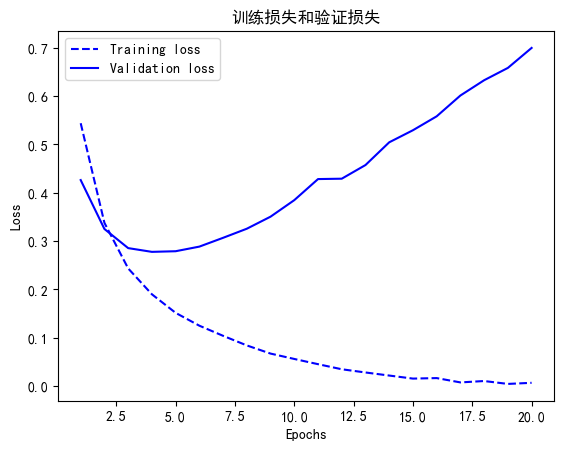

In [ ]:
# 3-9 绘制训练损失和验证损失
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b--', label='Training loss') # 'bo'是蓝色圆点
plt.plot(epochs, val_loss_values, 'b-', label='Validation loss') # 'b'是蓝色实线
plt.title('训练损失和验证损失')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

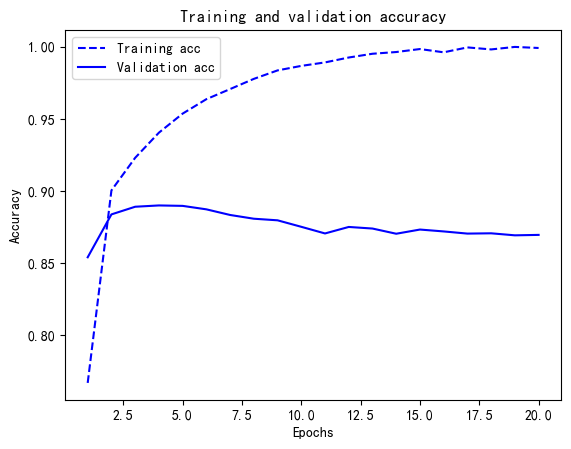

In [ ]:
# 3-10 绘制训练精度和验证精度
plt.clf() # 清空图像
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期结果——你想要最小化的量随着每次迭代越来越小。但验证损失和验证精度并非如此：它们似乎在第四轮达到最佳值。这就是我们之前警告过的一种情况：模型在训练数据上的表现越来越好，但在前所未见的数据上不一定表现得越来越好。准确地说，你看到的是过拟合（overfit）：在第二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之外的数据。

在这种情况下，为了防止过拟合，你可以在3轮之后停止训练。通常来说，你可以使用许多方法来降低过拟合，我们将在第4章中详细介绍。

我们从头开始训练一个新的网络，训练4轮，然后在测试数据上评估模型。

In [ ]:
# 3-11 从头开始重新训练一个模型
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 2s 70us/sample - loss: 0.4646 - acc: 0.8210
Epoch 2/4
25000/25000 [==============================] - 1s 47us/sample - loss: 0.2654 - acc: 0.9070
Epoch 3/4
25000/25000 [==============================] - 1s 48us/sample - loss: 0.2041 - acc: 0.9272
Epoch 4/4
25000/25000 [==============================] - 3s 103us/sample - loss: 0.2886 - acc: 0.8861


[0.2886226203727722, 0.88607997]

### 3.4.5　使用训练好的网络在新数据上生成预测结果
训练好网络之后，你希望将其用于实践。你可以用predict方法来得到评论为正面的可能性大小。

In [ ]:
model.predict(x_test)

array([[0.20417197],
       [0.9997584 ],
       [0.88453126],
       ...,
       [0.13712971],
       [0.07421432],
       [0.61245424]], dtype=float32)

如你所见，网络对某些样本的结果非常确信（大于等于0.99，或小于等于0.01），但对其他结果却不那么确信（0.6或0.4）。
### 3.4.6　进一步的实验
通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间。
* 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响。
* 尝试使用更多或更少的隐藏单元，比如32个、64个等。
* 尝试使用mse损失函数代替binary_crossentropy。
* 尝试使用tanh激活（这种激活在神经网络早期非常流行）代替relu。
### 小结
下面是你应该从这个例子中学到的要点。
* 通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码方式。
* 带有relu激活的Dense层堆叠，可以解决很多种问题（包括情感分类），你可能会经常用到这种模型。
* 对于二分类问题（两个输出类别），网络的最后一层应该是只有一个单元并使用sigmoid激活的Dense层，网络输出应该是0~1范围内的标量，表示概率值。
* 对于二分类问题的sigmoid标量输出，你应该使用binary_crossentropy损失函数。
* 无论你的问题是什么，rmsprop优化器通常都是足够好的选择。这一点你无须担心。
* 随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。一定要一直监控模型在训练集之外的数据上的性能。

## 3.5　新闻分类：多分类问题
上一节中，我们介绍了如何用密集连接的神经网络将向量输入划分为两个互斥的类别。但如果类别不止两个，要怎么做？

本节你会构建一个网络，将路透社新闻划分为46个互斥的主题。因为有多个类别，所以这是多分类（multiclass  classification）问题的一个例子。因为每个数据点只能划分到一个类别，所以更具体地说，这是单标签、多分类（single-label,  multiclass  classification）问题的一个例子。如果每个数据点可以划分到多个类别（主题），那它就是一个多标签、多分类（multilabel, multiclass classification）问题。

### 3.5.1　路透社数据集
本节使用路透社数据集，它包含许多短新闻及其对应的主题，由路透社在1986年发布。它是一个简单的、广泛使用的文本分类数据集。它包括46个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少10个样本。与IMDB和MNIST类似，路透社数据集也内置为Keras的一部分。我们来看一下。


In [ ]:
# 3-12 加载路透社数据集
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


2113536/2110848 [==============================] - 1s 1us/step


与IMDB数据集一样，参数num_words=10000将数据限定为前10,000个最常出现的单词。我们有8,982个训练样本和2,246个测试样本。

In [ ]:
len(train_data), len(test_data)

(8982, 2246)

与IMDB评论一样，每个样本都是一个整数列表（表示单词索引）。

In [ ]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

如果好奇的话，你可以用下列代码将索引解码为单词。

In [ ]:
# 3-13 将索引解码为新闻文本
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 注意，索引减去了3，因为0、1、2是为“padding”（填充）、“start of sequence”（序列开始）、
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
# 样本对应的标签是一个介于0-45之间的整数，即话题的索引
train_labels[10]


4

### 3.5.2 准备数据
你可以使用上个例子相同的代码将数据向量化

In [ ]:
# 3-14 准备数据
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
# 将训练数据向量化
x_train = vectorize_sequences(train_data)
# 将测试数据向量化
x_test = vectorize_sequences(test_data)

将标签向量化有两种方法：你可以将标签列表转换为整数张量，或者使用one-hot编码。one-hot编码是分类数据广泛使用的一种格式，也叫分类编码（categorical encoding）。6.1节给出了one-hot编码的详细解释。在这个例子中，标签的one-hot编码就是将每个标签表示为全零向量，只有标签索引对应的元素为1。其代码实现如下。

In [ ]:
# 46个话题的独热编码
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
# 将训练标签向量化
one_hot_train_labels = to_one_hot(train_labels)
# 将测试标签向量化
one_hot_test_labels = to_one_hot(test_labels)

注意，Keras内置方法可以实现这个操作，你在MNIST例子中已经见过这种方法。

In [ ]:
from tensorflow.keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### 3.5.3　构建网络
这个主题分类问题与前面的电影评论分类问题类似，两个例子都是试图对简短的文本片段进行分类。但这个问题有一个新的约束条件：输出类别的数量从2个变为46个。输出空间的维度要大得多。
对于前面用过的Dense层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。上一个例子使用了16维的中间层，但对这个例子来说16维空间可能太小了，无法学会区分46个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。
出于这个原因，下面将使用维度更大的层，包含64个单元。

In [ ]:
# 3-15 模型定义
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


关于这个架构还应该注意另外两点。
* 网络的最后一层是大小为46的Dense层。这意味着，对于每个输入样本，网络都会输出一个46维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。
* 最后一层使用了softmax激活。你在MNIST例子中见过这种用法。网络将输出在46个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个46维向量，其中output[i]是样本属于第i个类别的概率。46个概率的总和为1。

对于这个例子，最好的损失函数是categorical_crossentropy（分类交叉熵）。它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.4 验证你的方法
我们在训练数据中留出1000个样本作为验证集。

In [ ]:
# 3-16 留出验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

现在开始训练，共20个轮次

In [ ]:
# 3-18 训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 118us/sample - loss: 2.9000 - acc: 0.4422 - val_loss: 1.9592 - val_acc: 0.6310
Epoch 2/20
7982/7982 [==============================] - 0s 47us/sample - loss: 1.5673 - acc: 0.7007 - val_loss: 1.3871 - val_acc: 0.7160
Epoch 3/20
7982/7982 [==============================] - 0s 53us/sample - loss: 1.1229 - acc: 0.7697 - val_loss: 1.1717 - val_acc: 0.7520
Epoch 4/20
7982/7982 [==============================] - 0s 50us/sample - loss: 0.8738 - acc: 0.8162 - val_loss: 1.0752 - val_acc: 0.7640
Epoch 5/20
7982/7982 [==============================] - 0s 52us/sample - loss: 0.7017 - acc: 0.8532 - val_loss: 0.9864 - val_acc: 0.7940
Epoch 6/20
7982/7982 [==============================] - 0s 55us/sample - loss: 0.5622 - acc: 0.8837 - val_loss: 0.9389 - val_acc: 0.8120
Epoch 7/20
7982/7982 [==============================] - 0s 51us/sample - loss: 0.4585 - acc: 0.9072 - val_loss: 0.9000 - val_acc:

最后，我们来绘制损失曲线和精度曲线

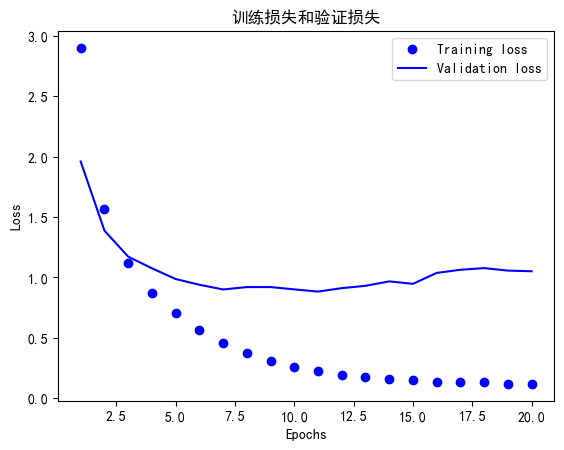

In [ ]:
# 3-19 绘制训练损失和验证损失
plt.clf() # 清空图像
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='训练损失') # 'bo'是蓝色圆点
plt.plot(epochs, val_loss_values, 'b-', label='验证损失') # 'b'是蓝色实线
plt.title('训练损失和验证损失')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

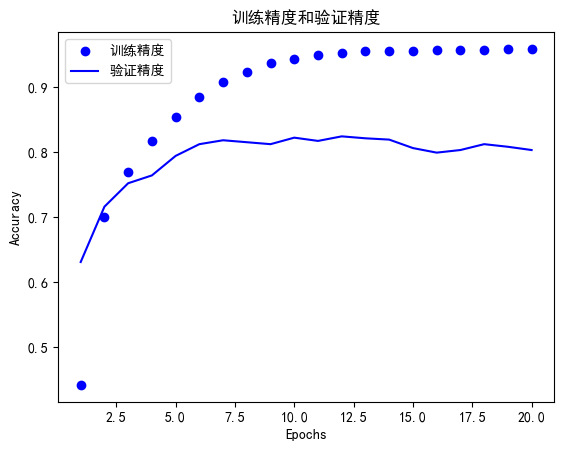

In [ ]:
# 3-20 绘制训练精度和验证精度
plt.clf() # 清空图像
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='训练精度')
plt.plot(epochs, val_acc, 'b-', label='验证精度')
plt.title('训练精度和验证精度')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

网络在训练9轮后开始过拟合。我们从头开始训练一个新网络，共9个轮次，然后在测试集上评估模型。

In [ ]:
# 3-21 从头开始重新训练一个模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train, 
          partial_y_train, 
          epochs=100, 
          batch_size=512, 
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/100
7982/7982 [==============================] - 1s 91us/sample - loss: 2.4589 - acc: 0.5283 - val_loss: 1.6597 - val_acc: 0.6620
Epoch 2/100
7982/7982 [==============================] - 0s 55us/sample - loss: 1.3700 - acc: 0.7155 - val_loss: 1.2809 - val_acc: 0.7180
Epoch 3/100
7982/7982 [==============================] - 1s 66us/sample - loss: 1.0152 - acc: 0.7848 - val_loss: 1.1030 - val_acc: 0.7610
Epoch 4/100
7982/7982 [==============================] - 0s 59us/sample - loss: 0.7976 - acc: 0.8322 - val_loss: 1.0016 - val_acc: 0.7930
Epoch 5/100
7982/7982 [==============================] - 0s 57us/sample - loss: 0.6338 - acc: 0.8685 - val_loss: 0.9384 - val_acc: 0.8040
Epoch 6/100
7982/7982 [==============================] - 0s 52us/sample - loss: 0.5081 - acc: 0.8931 - val_loss: 0.9228 - val_acc: 0.7980
Epoch 7/100
7982/7982 [==============================] - 0s 54us/sample - loss: 0.4040 - acc: 0.9167 - val_loss: 0.8657 - va

[2.388138162590835, 0.7542298]

这种方法可以得到约80%的精度。对于平衡的二分类问题，完全随机的分类器能够得到50%的精度。但在这个例子中，完全随机的精度约为19%，所以上述结果相当不错，至少和随机的基准比起来还不错。

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18477292965271594

### 3.5.5　在新数据上生成预测结果
你可以验证，模型实例的predict方法返回了在46个主题上的概率分布。我们对所有测试数据生成主题预测。

In [ ]:
predictions = model.predict(x_test)
# predictions中的每个元素都是长度为46的向量。>
print(predictions[0].shape)
# 这个向量的所有元素总和为1。
print(np.sum(predictions[0]))
# 最大的元素就是预测类别，即概率最大的类别。
print(np.argmax(predictions[0]))

(46,)
1.0
3


### 3.5.6　处理标签和损失的另一种方法
前面提到了另一种编码标签的方法，就是将其转换为整数张量，如下所示。
```
y_train = np.array(train_labels)
y_test = np.array(test_labels)
```
对于这种编码方法，唯一需要改变的是损失函数的选择。对于代码清单3-21使用的损失函数categorical_crossentropy，标签应该遵循分类编码。对于整数标签，你应该使用sparse_categorical_crossentropy。
```
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
```
这个新的损失函数在数学上与categorical_crossentropy完全相同，二者只是接口不同。

### 3.5.7　中间层维度足够大的重要性
前面提到，最终输出是46维的，因此中间层的隐藏单元个数不应该比46小太多。现在来看一下，如果中间层的维度远远小于46（比如4维），造成了信息瓶颈，那么会发生什么？

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 134us/sample - loss: 3.6606 - acc: 0.1503 - val_loss: 3.3987 - val_acc: 0.0960
Epoch 2/20
7982/7982 [==============================] - 1s 74us/sample - loss: 2.9920 - acc: 0.1165 - val_loss: 2.5919 - val_acc: 0.1350
Epoch 3/20
7982/7982 [==============================] - 1s 80us/sample - loss: 2.0943 - acc: 0.4250 - val_loss: 1.9003 - val_acc: 0.4770
Epoch 4/20
7982/7982 [==============================] - 1s 105us/sample - loss: 1.5923 - acc: 0.5200 - val_loss: 1.5751 - val_acc: 0.5070
Epoch 5/20
7982/7982 [==============================] - 1s 87us/sample - loss: 1.2075 - acc: 0.7001 - val_loss: 1.2931 - val_acc: 0.6810
Epoch 6/20
7982/7982 [==============================] - 1s 84us/sample - loss: 0.9903 - acc: 0.7583 - val_loss: 1.2491 - val_acc: 0.6950
Epoch 7/20
7982/7982 [==============================] - 1s 86us/sample - loss: 0.8839 - acc: 0.7749 - val_loss: 1.2159 - val_acc

现在网络的验证精度最大约为80%，比前面下降了8%。导致这一下降的主要原因在于，你试图将大量信息（这些信息足够恢复46个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。

### 3.5.8　进一步的实验
* 尝试使用更多或更少的隐藏单元，比如32个、128个等。
* 前面使用了两个隐藏层，现在尝试使用一个或三个隐藏层。
### 小结
下面是你应该从这个例子中学到的要点。
* 如果要对N个类别的数据点进行分类，网络的最后一层应该是大小为N的Dense层。
* 对于单标签、多分类问题，网络的最后一层应该使用softmax激活，这样可以输出在N个输出类别上的概率分布。
* 这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的真实分布之间的距离最小化。
* 处理多分类问题的标签有两种方法。
    * 通过分类编码（也叫one-hot编码）对标签进行编码，然后使用categorical_crossentropy作为损失函数。
    * 将标签编码为整数，然后使用sparse_categorical_crossentropy损失函数。
* 如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈。
## 3.6 预测房价：回归问题
前面两个例子都是分类问题，其目标是预测输入数据点所对应的单一离散的标签。另一种常见的机器学习问题是回归问题，它预测一个连续值而不是离散的标签，例如，根据气象数据预测明天的气温，或者根据软件说明书预测完成软件项目所需要的时间。

`注意不要将回归问题与logistic回归算法混为一谈。令人困惑的是，logistic回归不是回归算法，而是分类算法。`


### 3.6.1　波士顿房价数据集
本节将要预测20世纪70年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。本节用到的数据集与前面两个例子有一个有趣的区别。它包含的数据点相对较少，只有506个，分为404个训练样本和102个测试样本。输入数据的每个特征（比如犯罪率）都有不同的取值范围。例如，有些特性是比例，取值范围为0~1；有的取值范围为1~12；还有的取值范围为0~100，等等。

In [2]:
# 代码清单 3-24 加载波士顿房价数据集
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
# 看一下数据
print(train_data.shape)
print(test_data.shape)

2023-05-05 09:53:38.374851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(404, 13)
(102, 13)


如你所见，我们有404个训练样本和102个测试样本，每个样本都有13个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。

目标是房屋价格的中位数，单位是千美元。

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

房价大都在10 000~50 000美元。如果你觉得这很便宜，不要忘记当时是20世纪70年代中期，而且这些价格没有根据通货膨胀进行调整。

### 3.6.2　准备数据
将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。用Numpy可以很容易实现标准化。

In [3]:
# 3-25 数据标准化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，你不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行。
### 3.6.3　构建网络
由于样本数量很少，我们将使用一个非常小的网络，其中包含两个隐藏层，每层有64个单元。一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。

In [4]:
# 3-26 构建网络
from tensorflow.keras import models
from tensorflow.keras import layers
def build_model():
    # 因为需要将同一个模型多次实例化，所以用一个函数来构建模型。
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))  
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将会限制输出范围。例如，如果向最后一层添加sigmoid激活函数，网络只能学会预测0~1范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。

注意，编译网络用的是mse损失函数，即均方误差（MSE，mean squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数。

在训练过程中还监控一个新指标：平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。比如，如果这个问题的MAE等于0.5，就表示你预测的房价与实际价格平均相差500美元。
### 3.6.4　利用K折验证来验证你的方法
为了在调节网络参数（比如训练的轮数）的同时对网络进行评估，你可以将数据划分为训练集和验证集，正如前面例子中所做的那样。但由于数据点很少，验证集会非常小（比如大约100个样本）。因此，验证分数可能会有很大波动，这取决于你所选择的验证集和训练集。也就是说，验证集的划分方式可能会造成验证分数上有很大的方差，这样就无法对模型进行可靠的评估。

在这种情况下，最佳做法是使用K折交叉验证（见图3-11）。这种方法将可用数据划分为K个分区（K通常取4或5），实例化K个相同的模型，将每个模型在K-1个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于K个验证分数的平均值。这种方法的代码实现很简单。


In [5]:
# 3-27 k折验证
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


2023-05-05 09:53:52.345352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 09:53:52.346471: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
all_scores
np.mean(all_scores)

2.531008929014206

每次运行模型得到的验证分数有很大差异，从2.6到3.2不等。平均分数（3.0）是比单一分数更可靠的指标——这就是K折交叉验证的关键。在这个例子中，预测的房价与实际价格平均相差3000美元，考虑到实际价格范围在10 000~50 000美元，这一差别还是很大的。
我们让训练时间更长一点，达到500个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [1]:
# 3-28 保存每折的验证结果
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据：第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 
    # 准备训练数据：其他所有分区的数据
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    # 构建Keras模型（已编译）
    model = build_model()
    # 训练模型（静默模式，verbose=0）
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)


NameError: name 'k' is not defined

In [16]:
# 3-29 计算所有轮次中的K折验证分数平均值
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

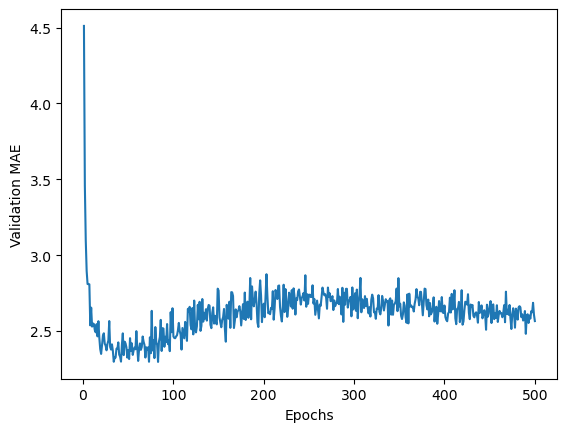

In [18]:
# 3-30 绘制验证分数
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。
* 删除前10个数据点，因为它们的取值范围与曲线上的其他点不同。
* 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。
结果如图所示。

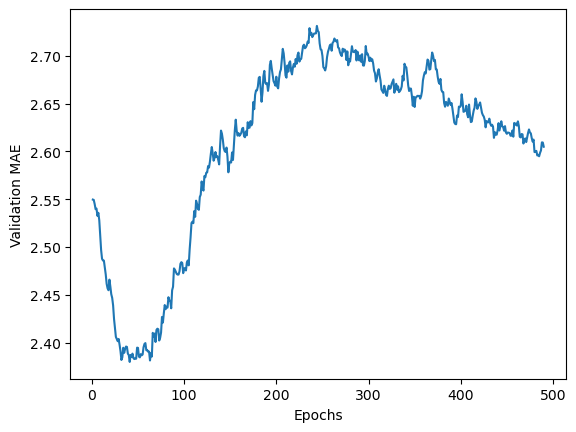

In [19]:
# 3-31 绘制验证分数（删除前10个数据点）
def soomth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            # 之前的平均值乘以平滑因子，与当前值乘以（1-平滑因子）
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = soomth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从图可以看出，验证MAE在80轮后不再显著降低，之后就开始过拟合。

完成模型调参之后（除了轮数，还可以调节隐藏层大小），你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。

In [20]:
# 3-32 训练最终模型
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mse_score)
print(test_mae_score)

4/4 [==============================] - 0s 1ms/step - loss: 19.1408 - mae: 2.8215
19.140758514404297
2.8215324878692627


### 3.6.5　小结
下面是你应该从这个例子中学到的要点。
* 回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。
* 同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）。
* 如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。
* 如果可用的数据很少，使用K折验证可以可靠地评估模型。
* 如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以避免严重的过拟合

### 本章小结
现在你可以处理关于向量数据最常见的机器学习任务了：二分类问题、多分类问题和标量回归问题。前面三节的“小结”总结了你从这些任务中学到的要点。
* 在将原始数据输入神经网络之前，通常需要对其进行预处理。
* 如果数据特征具有不同的取值范围，那么需要进行预处理，将每个特征单独缩放。
* 随着训练的进行，神经网络最终会过拟合，并在前所未见的数据上得到更差的结果。
* 如果训练数据不是很多，应该使用只有一两个隐藏层的小型网络，以避免严重的过拟合。
* 如果数据被分为多个类别，那么中间层过小可能会导致信息瓶颈。
* 回归问题使用的损失函数和评估指标都与分类问题不同。
* 如果要处理的数据很少，K折验证有助于可靠地评估模型。